<a href="https://colab.research.google.com/github/blackJJW/DL/blob/main/self_study_DL/chapter9_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 09-2 순환 신경망으로 IMDB 리뷰 분류하기

## IMDB 리뷰 데이터 셋

- IMDB 리뷰 데이터셋은 imdb.com에서 수집한 리뷰 감상평에 따라 긍정과 부정으로 분류해 놓은 데이터셋
- 총 50,000개의 샘플
- 훈련 데이터와 테스트 데이터 각각 25,000개

> 자연어 처리와 말뭉치
- **자연어 처리**(natural language processing, NLP) : 컴퓨터를 사용해 인간의 언어를 처리하는 분야
  - ex) 음성 인식, 기계 번역, 감성 분석 등
- **말뭉치**(corpus) : 자연어 처리 분야에서의 훈련 데이터

- 텍스트 자체를 신경망에 전달하지 않은.
  - 컴퓨터에서 처리하는 모든 것은 어떤 숫자 데이터
  - 텍스트 데이터의 경우 단어를 숫자 데이터로 바꾸는 방법 : 단어마다 고유한 정수를 부여
- **토큰**(token) : 영어 문장을 모두 소문자로 바꾸고 구둣점을 삭제한 다음 공백을 기준으로 분리한 단어
  - 하나의 샘플은 여러 개의 토큰으로 이루어져 있고 1개의 토큰이 하나의 타임스텝에 해당

> 한글 문장은 어떻게 토큰을 분리?
- 한글은 조사가 발달, 공백으로 나누는 것만으로는 부족
- 일반적으로 한글은 형태소 분석을 통해 토큰을 생성

- 토큰에 할당하는 정수 중에 몇 개는 특정한 용도로 예약
  - 0 : 패딩
  - 1 : 문장의 시작
  - 2 : 어휘 사전에 없는 토큰


> 어휘 사전
- 훈련 세트에서 고유한 단어를 뽑아 만든 목록
- ex) 테스트 세트 안에 어휘 사전에 없는 단어가 았다면 2로 변환하여 신경망 모델에 주입

- tensorflow.keras.datasets 패키지 아래 imdb 모듈을 임포트
- 가장 자주 등장하는 단어 500개

In [1]:
from tensorflow.keras.datasets import imdb
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)

17473536/17464789 [==============================] - 0s 0us/step


In [2]:
print(train_input.shape, test_input.shape)

(25000,) (25000,)


- IMDB 리뷰 텍스트는 길이가 제각각
- 고정 크기의 2차원 배열에 담기 보다는 리뷰마다 별도의 파이썬 리스트로 담아야 메모리를 효율적으로 사용 가능


```
train_input: [리뷰1, 리뷰2, 리뷰3, ...] <- 넘파이 배열
```
- 이 데이터는 개별 리뷰를 담은 파이썬 리스트 객체로 이루어진 넘파이 배열
- 넘파이 배열은 정수나 실수 외에도 파이썬 객체를 담을 수 있음



In [3]:
print(len(train_input[0]))

218


In [4]:
print(len(train_input[1]))

189


In [5]:
print(train_input[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


- 텐서플로에 있는 IMDB 리뷰 데이터는 이미 정수로 변환

In [6]:
print(train_target[:20])

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


- 해결할 문제는 리뷰가 긍정인지 부정인지 판단하는 것
  - 이진 분류 문제로 볼 수 있으며 타깃값이 0(부정)과 1(긍정)로 나누어짐

In [7]:
from sklearn.model_selection import train_test_split
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

- 각 리뷰의 길이를 계산하여 넘파이 배열에 담음
  - 평균적인 리뷰의 길이와 가장 짧은 리뷰의 길이 그리고 가장 긴 리뷰의 길이를 확인 하고자 함

In [8]:
import numpy as np
lengths = np.array([len(x) for x in train_input])

In [9]:
print(np.mean(lengths), np.median(lengths))

239.00925 178.0


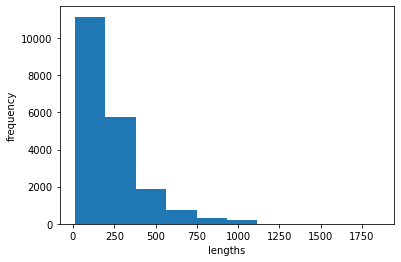

In [10]:
import matplotlib.pyplot as plt
plt.hist(lengths)
plt.xlabel('lengths')
plt.ylabel('frequency')
plt.show()

- 대부분의 리뷰 길이는 300 미만
- 리뷰는 대부분 짧아서 중간값보다 훨씬 짧은 100개의 단어만 사용
  - 하지만 100개의 단어보다 작은 리뷰 존재
  - 이런 리뷰들의 길이를 맞추기 위해 패딩이 필요
    - 보통 패딩을 나타내는 토큰 : 0

- 케라스는 시퀀스 데이터의 길이를 맞추는 pad_squences() 함수를 제공
- 이 함수를 사용해 train_input의 길이를 100으로 맞춤

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(train_input, maxlen=100)

- maxlen에 원하는 길이를 지정하면 이보다 긴 경우는 잘라내고 짧은 경우는 0으로 패딩

In [12]:
print(train_seq.shape)

(20000, 100)


- train_input은 파이썬 리스트의 배열이었지만, 길이를 100으로 맞춘 train_seq는 이제 (20000, 100) 크기의 2차원 배열이 되었음

In [13]:
print(train_seq[0])

[ 10   4  20   9   2 364 352   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10 451   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10 470 158]


In [14]:
print(train_input[0][-10:])

[6, 2, 46, 7, 14, 20, 10, 10, 470, 158]


- 음수 인덱스와 슬라이싱을 사용해 train_input[0]에 있는 마지막 10개의 토큰을 출력
- train_seq[0]의 출력값과 비교하면 정확히 일치
  - 샘플의 앞부분이 잘렸음을 짐작

- pad_sequences() 함수는 기본으로 maxlen보다 긴 시퀀스의 앞부분을 자름
  - 일반적으로 시퀀스의 뒷부분의 정보가 더 유용하리라 기대하기 때문

- 시퀀스의 뒷부분을 잘라내고 싶다면 pad_sequences() 함수의 truncating 매개변수의 값을 기본값 'pre'가 아닌 'post'로 바꾸면 됨

In [15]:
print(train_seq[5])

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2 352   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94 364 352   2   2  11 190
  24 484   2   7  94 205 405  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


- 앞부분에 0이 있는 것으로 보아 이 샘플의 길이는 100이 안됨
  - 같은 이유로 패딩 토큰은 시퀀스의 뒷부분이 아닌 앞부분에 추가
- 시원스의 마지막에 있는 단어가 셀의 은닉 상테에 가장 큰 영향을 미치게 되므로 마지막에 패딩을 추가하는 것은 일반적으로 선호하지 않음
  - 하지만 원한다면 pad_sequences() 함수의 padding 매개변수의 기본값인 'pre'를 'post'로 바꾸면 샘플의 뒷부분에 패딩을 추가 가능

- 검증 세트의 길이도 100으로 맞춤

In [16]:
val_seq = pad_sequences(val_input, maxlen=100)

## 순환 신경망 만들기

- 케라스는 여러 종류의 순환층 클래스를 제공
- 그중 가장 간단한 것은 SimpleRNN 클래스
- IMDB 리뷰 분류 문제는 이진 분류이므로 마지막 출력층은 1개의 뉴런을 가지고 시그모이드 활성화 함수를 사용해야 함

- 케라스의 Sequential 클래스로 만든 신경망 코드

> Sequential 클래스가 순환 신경망을 만드는 용도?
- Sequential 클래스는 순환 신경망뿐만 아니라 합성곱 신경망이나 일반적인 인공 신경망 모델을 모두 만들 수 있음
- 순차 데이터(Sequential data)와 관련이 없음

In [17]:
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(8, input_shape=(100, 500)))
model.add(keras.layers.Dense(1, activation='sigmoid'))

- 첫 번째 매개변수는 사용할 뉴런의 개수로 input_shape에 입력 차원을 (100, 500)으로 지정
- 첫 번째 차원이 100인 것은 앞에서 샘플의 길이를 100으로 지정했기 때문

- 순환층도 당연히 활성화 함수를 사용해야 함
- SimpleRNN 클래스의 activation 매개변수의 기본값 'tanh'로 하이퍼볼릭 탄젠트 함수를 사용
  - 여기서는 기본값을 사용

- input_shape의 두 번쩨 차원인 500인 이유
  - 이전 섹션에서 만든 train_seq와 val_seq에는 한 가지 문제가 존재
    - 토큰을 정수로 변환한 이 데이터를 신경망에 주입하면 큰 정수가 큰 활성화 출력을 만들기 때문
  - 단순한 정숫값을 신경망에 입력하기 위해서는 다른 방법을 찾아야 함
  - 정숫값에 있는 크기 속성을 없애고 각 정수를 고유하게 표현하는 방법은 원-핫 인코딩

- imdb.load_data() 함수에서 500개의 단어만 사용하도록 지정했기 때문에 고유한 단어는 모두 500개
  - 훈련 데이터에 포함될 수 있는 정숫값의 범위는 0(패딩 토큰)에서 499까지
  - 따라서 이 범위를 원-핫 인코딩으로 표현하려면 배열의 길이가 500이어야 함

- 토큰마다 500개의 숫자를 사용해 표현
  - 다만 500개 중에 하나만 1이고 나머지는 모두 0으로 만드러 정수 사이에 있던 크기 속성을 없애는 원-핫 인코딩을 사용 

- keras.utils 패키지 아래에 있는 to_categorical() 함수
  - 정수 배열을 입력하면 자동으로 원-핫 인코딩된 배열을 반환

In [18]:
train_oh = keras.utils.to_categorical(train_seq)

In [19]:
print(train_oh.shape)

(20000, 100, 500)


- 정수 하나마다 모두 500차원의 배열로 변경되었기 때문에 (20000, 100) 크기의 train_seq가 (20000, 100, 500) 크기의 train_oh로 바뀜
- 샘플 데이터의 크기가 1차원 정수 배열 (100, )에서 2차원 배열 (100, 500)로 바꿔야 하므로 SimpleRNN 클래스의 input_shape 매개변수의 값을 (100, 500)으로 지정

In [20]:
print(train_oh[0][0][:12])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


- 처음 12개 원소를 출력해 보면 열한 번째 원소가 1인 것을 확인 가능

In [21]:
print(np.sum(train_oh[0][0]))

1.0


- 나머지 원소가 전부 0인 것을 확인
- 토큰 10이 잘 인코딩됨

- 같은 방식으로 val_seq도 원-핫 인코딩으로 변환

In [22]:
val_oh = keras.utils.to_categorical(val_seq)

- 모델의 구조를 출력

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 4072      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________


- SimpleRNN에 전달할 샘플의 크기는 (100, 500)이지만 이 순환층은 마지막 타임스텝의 은닉 상태만 출력
- 출력 크기가 순환층의 뉴런 개수와 동일한 8임을 확인

- 순환층에 사용된 모델 파라미터의 개수를 계산
  - 입력 토큰은 500차원의 원-핫 인코딩 배열
  - 이 배열이 순환층의 뉴런 8개와 완전히 연결되기 때문에 총 $500 \times 8 = 4000$개의 가중치가 있음
  - 순환층의 은닉 상태는 다시 다음 타임스텝에 사용되기 위해 또 다른 가중치와 곱해짐
  - 이 은닉 상태도 순환층의 뉴런과 완전히 연결되기 때문에 $8(은닉 상태 크기)\times 8(뉴런 개수) = 64$개의 가중치가 필요
  - 마지막으로 뉴런마다 하나의 절편이 존재
    - $4000 + 64 + 8 = 4072$개의 모델 파라미터가 필요

## 순환 신경망 훈련하기

- 이 예에서는 기본 RMSprop의 학습률 0.001을 사용하지 않기 위해 별도의 RMSprop 객체를 만들어 학습률을 0.001로 지정
- 에포크 횟수를 100으로, 배치 크기를 64개로 설정

In [24]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy',
              metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5',
                                                save_best_onlu = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights = True)
history = model.fit(train_oh, train_target, epochs=100, batch_size=64, 
                    validation_data=(val_oh, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 31s 85ms/step - loss: 0.7004 - accuracy: 0.4995 - val_loss: 0.7015 - val_accuracy: 0.4874
Epoch 2/100
313/313 [==============================] - 26s 82ms/step - loss: 0.6961 - accuracy: 0.5068 - val_loss: 0.6984 - val_accuracy: 0.4920
Epoch 3/100
313/313 [==============================] - 25s 80ms/step - loss: 0.6932 - accuracy: 0.5163 - val_loss: 0.6962 - val_accuracy: 0.5020
Epoch 4/100
313/313 [==============================] - 35s 111ms/step - loss: 0.6910 - accuracy: 0.5275 - val_loss: 0.6946 - val_accuracy: 0.5030
Epoch 5/100
313/313 [==============================] - 26s 81ms/step - loss: 0.6890 - accuracy: 0.5373 - val_loss: 0.6931 - val_accuracy: 0.5146
Epoch 6/100
313/313 [==============================] - 25s 80ms/step - loss: 0.6840 - accuracy: 0.5591 - val_loss: 0.6851 - val_accuracy: 0.5580
Epoch 7/100
313/313 [==============================] - 25s 80ms/step - loss: 0.6760 - accuracy: 0.5914 - val_loss: 0.6787 - val_a

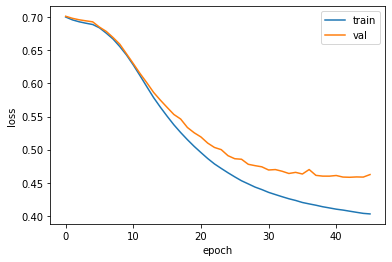

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

- 훈련 손실은 꾸준히 감소하고 있지만 검증 손실은 대략 20번째에서 감소가 둔해짐
- 원-핫 인코딩의 단점은 입력 데이터가 엄청나게 커진다는 것

In [26]:
print(train_seq.nbytes, train_oh.nbytes)

8000000 4000000000


- 토큰 1개를 500차원으로 늘렸기 때문에 대략 500배가 커짐
- 훈련 데이터가 커질수록 더 문제가 됨

## 단어 임베딩을 사용하기

- 순환 신경망에서 텍스트를 처리할 때 즐려 사용하는 방법은 단어 임베딩(word embedding)
- 단어 임베딩은 각 단어를 고정된 크기의 실수 벡터로 바꾸어줌
- 단어 임베딩으로 만들어진 벡터는 원-핫 인코딩된 벡터보다 훨씬 의미 있는 값으로 채워져 있기 때문에 자연어 처리에서 더 좋은 성능을 내는 경우가 많음

- keras.layers 패키지 아래 Embedding 클래스로 임베딩 기능을 제공
- 이 클래스를 다른 층처럼 모델에 추가하면 처음에는 모든 벡터가 랜덤하게 초기화되지만 훈련을 통해 데이터에서 좋은 단어 임베딩을 학습

- 단어 임베딩의 장점은 입력으로 정수 데이터를 받는 것
  - 원-핫 인코딩으로 변경된 train_oh 배열이 아니라 train_seq를 사용할 수 있음
  - 메모리를 훨씬 효울적으로 사용 가능

- 원-핫 인코딩은 샘플 하나를 500차원으로 늘렸기 때문에 (100, ) 크기의 샘플이 (100, 500)으로 커짐
- 임베딩도 (100, ) 크기의 샘플을 (100, 20)과 같이 2차원 배열로 늘림
- 하지만 원-핫 인코딩과는 달리 훨씬 작은 크기로도 단어를 잘 표현 가능

- Embedding 클래스를 SimpleRNN 층 앞에 추가한 두 번째 순환 신경망을 생성

In [32]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

- Embedding 클래스의 첫 번째 매개변수 (500)는 어휘 사전의 크기
  - 앞서 IMDB 리뷰 데이터셋에서 500개의 단어만 사용하도록 imdb.load_data(num_words=500)과 같이 설정했기 때문에 이 매개변수의 값을 500으로 지정

- 두 번째 매개변수 (16)는 임베딩 벡터의 크기
  - 원-핫 인코딩보다 훨씬 작은 크기 (16)의 벡터를 사용

- 세 번째 input_length 매개변수는 입력 시퀀스의 길이
  - 앞서 샘플의 길이를 100으로 맞추어 train_seq를 생성
  - 따라서 100으로 지정

- SimpleRNN 층과 Dense 층은 이전과 동일

In [33]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 16)           8000      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 8)                 200       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,209
Trainable params: 8,209
Non-trainable params: 0
_________________________________________________________________


- 이 모델은 (100, ) 크기의 입력을 받아 (100, 16) 크기의 출력을 생성

- Embedding 클래스는 500개의 각 토큰을 크기가 16인 벡터로 변경하기 때문데 총 $500 \times 16 = 8000$개의 모델 파라미터를 가짐
- 그 다음 SimpleRNN 층은 임베딩 벡터의 크기가 16이므로 8개의 뉴런과 곱하기 위해 필요한 가중치 $16 \times 8 =128$개를 가짐
- 은닉 상태에 곱해지는 $8\times 8 = 64$개가 있음
- 마지막으로 8개의 절편이 존재
  - $128 + 64 + 8 = 200$개의 모델 파라미터

- 마지막 Dense 층의 가중치 개수는 이전과 동일하게 9개
- 원-핫 인코딩보다 SimpleRNN에 주입되는 입력의 크기가 크게 줄었지만 임베딩 벡터는 단어를 잘 표현하는 능력이 있기 때문에 훈련 결과는 이전에 못지 않음
- 훈련 과정은 이전과 동일

In [34]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy',
              metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.h5',
                                                save_best_onlu = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights = True)
history = model2.fit(train_seq, train_target, epochs=100, batch_size=64, 
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 32s 99ms/step - loss: 0.6949 - accuracy: 0.5070 - val_loss: 0.6948 - val_accuracy: 0.5012
Epoch 2/100
313/313 [==============================] - 31s 98ms/step - loss: 0.6913 - accuracy: 0.5238 - val_loss: 0.6930 - val_accuracy: 0.5136
Epoch 3/100
313/313 [==============================] - 31s 99ms/step - loss: 0.6883 - accuracy: 0.5418 - val_loss: 0.6916 - val_accuracy: 0.5224
Epoch 4/100
313/313 [==============================] - 31s 99ms/step - loss: 0.6852 - accuracy: 0.5553 - val_loss: 0.6906 - val_accuracy: 0.5248
Epoch 5/100
313/313 [==============================] - 31s 100ms/step - loss: 0.6819 - accuracy: 0.5654 - val_loss: 0.6898 - val_accuracy: 0.5256
Epoch 6/100
313/313 [==============================] - 31s 98ms/step - loss: 0.6784 - accuracy: 0.5796 - val_loss: 0.6892 - val_accuracy: 0.5296
Epoch 7/100
313/313 [==============================] - 31s 101ms/step - loss: 0.6747 - accuracy: 0.5874 - val_loss: 0.6883 - val_

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

- 검증 손실이 더 감소되지 않아 훈련이 적절히 조기 종료
- 이에 비해 훈련 손실은 계속 감소

## 마무리

### 키워드로 끝내는 핵심 포인트

- 말뭉치 : 자연어 처리에서 사용하는 텍스트 데이터의모음, 즉 훈련 데이터셋
- 토큰 : 텍스트에서 공백으로 구분되는 문자열. 종종 소문자로 변환하고 구둣점은 삭제
- 원-핫 인코딩 : 어떤 클래스에 해당하는 원소만 1이고 나머지는 모두 0인 벡터.
  - 정수로 변환된 토큰을 원-핫 인코딩으로 변환하려면 어휘 사전 크기의 벡터가 생성
- 단어 임베딩 : 정수로 변환된 토큰을 비교적 작은 크기의 실수 밀집 벡터로 변환
  - 이런 밀집 벡터는 단어 사이의 관계를 표현할 수 있기 때문에 자연어 처리에서 좋은 성능을 발휘

### 핵심 패키지와 함수

> TensorFlow
- pad_sequences() : 시퀀스 길이를 맞추기 위해 패딩을 추가
  - 이 함수는 (샘플 개수, 타임스텝 개수) 크기의 2차원 배열을 기대
  - maxlen : 원하는 시퀀스 길이를 지정
    - 이 값보다 긴 시퀀스는 잘리고 짧은 시퀀스는 패딩
    - 이 매개변수를 지정하지 않으면 가장 긴 시퀀스의 길이가 됨
  - padding : 패딩을 추가할 위치를 지정
    - 'pre' : 기본값
      - 시퀀스 앞에 패딩을 추가
    - 'post' : 시퀀스 뒤에 패딩을 추가
  - 'truncating' : 긴 시퀀에서 잘라버릴 위치를 지정
    - 'pre' : 시퀀스 앞부분을 잘라냄
    - 'post' : 시퀀스 뒷부분을 잘라냄
- to_categorical() : 정수 시퀀스를 원-핫 인코딩으로 변환
  - 토큰을 원-핫 인코딩하거나 타깃값을 원-핫 인코딩할 때 사용
  - num_classes : 클래스 개수를 지정
    - 지정하지 않으면 데이터에서 자동으로 찾음
- SimpleRNN : 케라스의 기본 순환층 클래스
  - 첫 번째 매개변수 : 뉴런의 개수를 지정
  - activation : 매개변수에서 활성화 함수를 지정
    - 'tanh' : 기본값, 하이퍼볼릭 탄젠트
    - dropout : 입력에 대한 드롭아웃 비율을 지정
    - return_sequences : 모든 타임스텝의 은닉 상태를 출력할지 결정
      - 기본값 : False
- Embedding : 단어 임베딩을 위한 클래스
  - 첫 번째 매개변수 : 어휘 사전의 크기를 지정
  - 두 번째 매개변수 : Embedding 층이 출력할 밀집 벡터의 크기를 지정
  - input_length : 입력 시퀀스의 길이를 지정
    - Embedding 층 바로 뒤에 Flatten이나 Dense 클래스가 올 때 꼭 필요